In [173]:
import os
os.chdir('/workspaces/walker')
import numpy as np
import pandas as pd
import seaborn as sns

In [174]:
# generate random data
nrows = 1000
raw_df = pd.concat([
    pd.DataFrame({
        'segment': np.random.choice(['A', 'A', 'A', 'A', 'A', 'B', 'C'], size=nrows),
        'time': np.random.choice(['01-Jan'], size=nrows),
        'outcome': np.random.choice([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], size=nrows),
    }),
    pd.DataFrame({
        'segment': np.random.choice(['A', 'B', 'B', 'B', 'B', 'C'], size=nrows),
        'time': np.random.choice(['02-Feb'], size=nrows),
        'outcome': np.random.choice([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], size=nrows),
    }),
    pd.DataFrame({
        'segment': np.random.choice(['A', ], size=nrows),
        'time': np.random.choice(['02-Feb'], size=nrows),
        'outcome': np.random.choice([0, 1, 1, 1], size=nrows),
    }),
    pd.DataFrame({
        'segment': np.random.choice(['A', ], size=nrows),
        'time': np.random.choice(['01-Jan'], size=nrows),
        'outcome': np.random.choice([0, 1, 1, 1], size=nrows),
    })
])

In [175]:
aggs = raw_df \
    .groupby(['segment', 'time'], as_index=False) \
    .agg(
        count=('outcome', 'count'),
        performance=('outcome', 'mean')
    )
aggs

,segment,time,count,performance
0,A,01-Jan,1709,0.466355
1,A,02-Feb,1165,0.709871
2,B,01-Jan,142,0.105634
3,B,02-Feb,648,0.293210
4,C,01-Jan,149,0.073826
5,C,02-Feb,187,0.294118


In [176]:
pivot = aggs.pivot(
    index='segment',
    columns='time',
    values=['count', 'performance']
)
pivot.columns = ['|'.join(col).strip() for col in pivot.columns.values]
pivot = pivot.reset_index()
pivot

,segment,count|01-Jan,count|02-Feb,performance|01-Jan,performance|02-Feb
0,A,1709.0,1165.0,0.466355,0.709871
1,B,142.0,648.0,0.105634,0.293210
2,C,149.0,187.0,0.073826,0.294118


In [177]:
segments = np.sort(raw_df['segment'].unique()).tolist()
times = np.sort(raw_df['time'].unique()).tolist()

In [178]:
# calculate total counts
total_p0 = pivot[f'count|{times[0]}'].sum()
total_p1 = pivot[f'count|{times[1]}'].sum()

In [179]:
# convert counts to proportions
pivot[f'proportion|{times[0]}'] = pivot[f'count|{times[0]}'] / total_p0
pivot[f'proportion|{times[1]}'] = pivot[f'count|{times[1]}'] / total_p1

In [180]:
# calculate changes and averages
pivot['change_proportion'] = pivot[f'proportion|{times[1]}'] - pivot[f'proportion|{times[0]}']
pivot['change_performance'] = pivot[f'performance|{times[1]}'] - pivot[f'performance|{times[0]}']
pivot['average_proportion'] = (pivot[f'proportion|{times[0]}'] + pivot[f'proportion|{times[1]}']) / 2
pivot['average_performance'] = (pivot[f'performance|{times[0]}'] + pivot[f'performance|{times[1]}']) / 2

In [181]:
# overall performance at each time point
overall_performance_0 = (pivot[f'proportion|{times[0]}'] * pivot[f'performance|{times[0]}']).sum()
overall_performance_1 = (pivot[f'proportion|{times[1]}'] * pivot[f'performance|{times[1]}']).sum()
overall_performance_change = overall_performance_1 - overall_performance_0

In [182]:
# decomposition of total change
pivot['within_group_contribution'] = pivot['average_proportion'] * pivot['change_performance']
pivot['between_group_contribution'] = pivot['average_performance'] * pivot['change_proportion']
pivot['interaction_contribution'] = pivot['change_proportion'] * pivot['change_performance']

In [183]:
# sum up the effects
within_group_contribution = pivot['within_group_contribution'].sum()
between_group_contribution = pivot['between_group_contribution'].sum()
interaction_contribution = pivot['interaction_contribution'].sum()
total_contribution = within_group_contribution + between_group_contribution + interaction_contribution


In [184]:
total_contribution

np.float64(0.10990576822794838)

In [185]:
pivot

,segment,count|01-Jan,count|02-Feb,performance|01-Jan,performance|02-Feb,proportion|01-Jan,proportion|02-Feb,change_proportion,change_performance,average_proportion,average_performance,within_group_contribution,between_group_contribution,interaction_contribution
0,A,1709.0,1165.0,0.466355,0.709871,0.8545,0.5825,-0.272,0.243517,0.7185,0.588113,0.174967,-0.159967,-0.066237
1,B,142.0,648.0,0.105634,0.293210,0.0710,0.3240,0.253,0.187576,0.1975,0.199422,0.037046,0.050454,0.047457
2,C,149.0,187.0,0.073826,0.294118,0.0745,0.0935,0.019,0.220292,0.0840,0.183972,0.018505,0.003495,0.004186


In [186]:
pretty_results = pd.concat([
    pivot.loc[:, [
        'segment',
        f'count|{times[0]}',
        f'proportion|{times[0]}',
        f'count|{times[1]}',
        f'proportion|{times[1]}',
        'change_proportion',

        f'performance|{times[0]}',
        f'performance|{times[1]}',
        'change_performance',

        'within_group_contribution',
        'between_group_contribution',
        'interaction_contribution',
    ]],
    pd.DataFrame({
        'segment': 'Total',
        f'count|{times[0]}': total_p0,
        f'proportion|{times[0]}': 1,
        f'count|{times[1]}': total_p1,
        f'proportion|{times[1]}': 1,
        'change_proportion': np.nan,

        f'performance|{times[0]}': overall_performance_0,
        f'performance|{times[1]}': overall_performance_1,
        'change_performance': overall_performance_change,

        'within_group_contribution': within_group_contribution,
        'between_group_contribution': between_group_contribution,
        'interaction_contribution': interaction_contribution,
    }, index=[len(segments)])
])
pretty_results['total_contribution'] = pretty_results['within_group_contribution'] + pretty_results['between_group_contribution'] + pretty_results['interaction_contribution']
for col in ['within_group_contribution', 'between_group_contribution', 'interaction_contribution', 'total_contribution']:
    pretty_results[col+'_pct'] = pretty_results[col] / total_contribution
pretty_results

,segment,count|01-Jan,proportion|01-Jan,count|02-Feb,proportion|02-Feb,change_proportion,performance|01-Jan,performance|02-Feb,change_performance,within_group_contribution,between_group_contribution,interaction_contribution,total_contribution,within_group_contribution_pct,between_group_contribution_pct,interaction_contribution_pct,total_contribution_pct
0,A,1709.0,0.8545,1165.0,0.5825,-0.272,0.466355,0.709871,0.243517,0.174967,-0.159967,-0.066237,-0.051237,1.591970,-1.455490,-0.602667,-0.466186
1,B,142.0,0.0710,648.0,0.3240,0.253,0.105634,0.293210,0.187576,0.037046,0.050454,0.047457,0.134957,0.337073,0.459063,0.431795,1.227931
2,C,149.0,0.0745,187.0,0.0935,0.019,0.073826,0.294118,0.220292,0.018505,0.003495,0.004186,0.026186,0.168367,0.031804,0.038083,0.238255
3,Total,2000.0,1.0000,2000.0,1.0000,NaN,0.411500,0.536000,0.124500,0.230518,-0.106018,-0.014594,0.109906,2.097411,-0.964622,-0.132789,1.000000


# Proportion Change

<Axes: xlabel='segment', ylabel='count'>

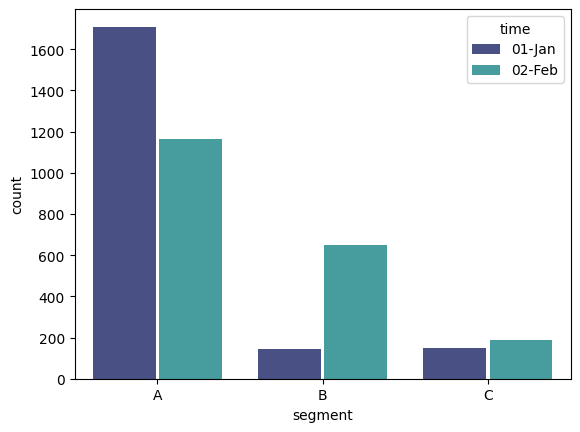

In [187]:
sns.set_palette(sns.color_palette("mako", 2))
sns.barplot(aggs, x="segment", y="count", hue="time", gap=0.05)

In [188]:
pretty_results_proportion = pretty_results.loc[:, [
    'segment',
    f'count|{times[0]}',
    f'proportion|{times[0]}',
    f'count|{times[1]}',
    f'proportion|{times[1]}',
    'change_proportion',
    'between_group_contribution',
    'between_group_contribution_pct',
]]
pretty_results_proportion

,segment,count|01-Jan,proportion|01-Jan,count|02-Feb,proportion|02-Feb,change_proportion,between_group_contribution,between_group_contribution_pct
0,A,1709.0,0.8545,1165.0,0.5825,-0.272,-0.159967,-1.455490
1,B,142.0,0.0710,648.0,0.3240,0.253,0.050454,0.459063
2,C,149.0,0.0745,187.0,0.0935,0.019,0.003495,0.031804
3,Total,2000.0,1.0000,2000.0,1.0000,NaN,-0.106018,-0.964622


# Performance Change

<Axes: xlabel='segment', ylabel='performance'>

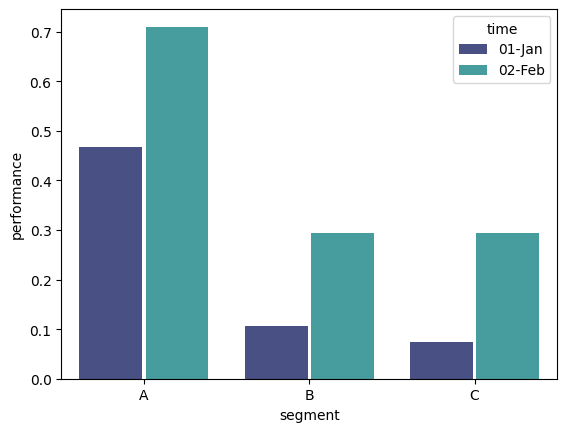

In [189]:
sns.set_palette(sns.color_palette("mako", 2))
sns.barplot(aggs, x="segment", y="performance", hue="time", gap=0.05)

In [190]:
pretty_results_performance = pretty_results.loc[:, [
    'segment',
        f'performance|{times[0]}',
        f'performance|{times[1]}',
        'change_performance',
    'between_group_contribution',
    'between_group_contribution_pct',
]]
pretty_results_performance

,segment,performance|01-Jan,performance|02-Feb,change_performance,between_group_contribution,between_group_contribution_pct
0,A,0.466355,0.709871,0.243517,-0.159967,-1.455490
1,B,0.105634,0.293210,0.187576,0.050454,0.459063
2,C,0.073826,0.294118,0.220292,0.003495,0.031804
3,Total,0.411500,0.536000,0.124500,-0.106018,-0.964622


# Absolute Contributions

In [191]:
pretty_results_condensed = pretty_results.loc[:, [
    'segment',
    'within_group_contribution',
    'between_group_contribution',
]]
pretty_results_condensed

,segment,within_group_contribution,between_group_contribution
0,A,0.174967,-0.159967
1,B,0.037046,0.050454
2,C,0.018505,0.003495
3,Total,0.230518,-0.106018
